In [32]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *
import pandas

# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
beta = HaloModel.SausageBeta
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)


# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)

# v_mins
n = 1000
v_min = linspace(0.01,750.0,n)

# Times
ndays = 100
days = linspace(0.0,365.0-365.0/ndays,ndays)

# Calculate everything
gmin_Iso = zeros(shape=(ndays,n))
gmin_Iso_gf = zeros(shape=(ndays,n))
gmin_Saus = zeros(shape=(ndays,n))
gmin_Saus_gf = zeros(shape=(ndays,n))
gmin_sub = zeros(shape=(ndays,n))
gmin_sub_gf = zeros(shape=(ndays,n))
for i in range(0,ndays):
    gmin_Iso[i,:] = gvmin_Triaxial(v_min,days[i],sig_iso)
    gmin_Iso_gf[i,:] = gvmin_Triaxial(v_min,days[i],sig_iso,GravFocus=True)
    
    gmin_Saus[i,:] = gvmin_Triaxial(v_min,days[i],sig_beta)
    gmin_Saus_gf[i,:] = gvmin_Triaxial(v_min,days[i],sig_beta,GravFocus=True)

    for isub in range(0,nshards):
        v_s = velocities[isub,:]
        sig_s = dispersions[isub,:]
        gmin_sub[i,:] += weights[isub]*gvmin_Triaxial(v_min,days[i],sig_s,v_shift=v_s)
        gmin_sub_gf[i,:] += weights[isub]*gvmin_Triaxial(v_min,days[i],sig_s,v_shift=v_s,GravFocus=True)
        
    print(i)

/Users/ciaranohare/Work/Zaragoza/HaloSpin/code/HaloFuncs.py:53: RuntimeWarning: invalid value encountered in double_scalars
  *erfi(v_esc/(sqrt(2)*sigr)*sqrt(beta/(1-beta)))

0
1
2
3
4
5
6
7
8
9


(0.0, 700.0)

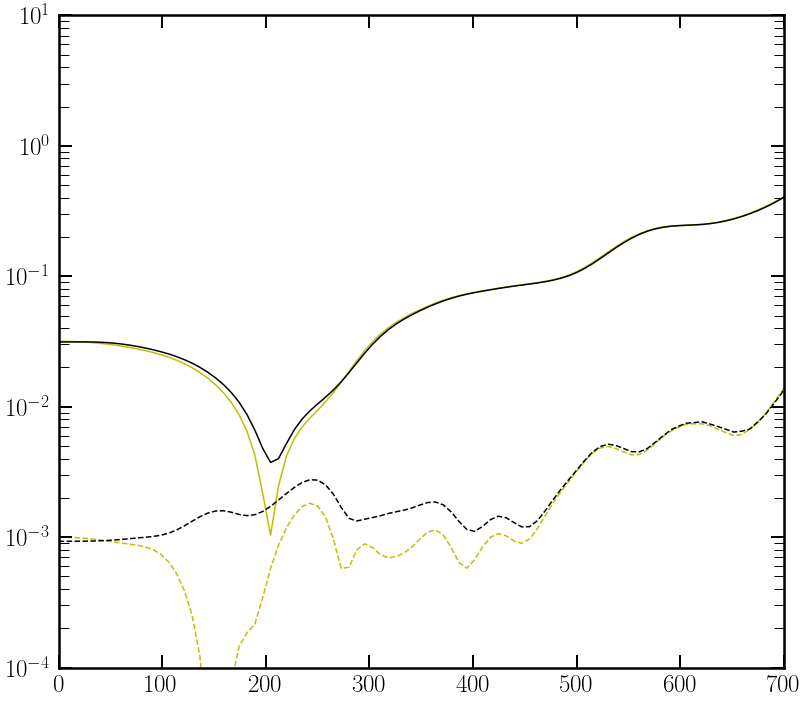

In [36]:
from PlotFuncs import *

from numpy.fft import fft

nt = size(days)
zorder =0

# Get all fourier components
def FourierComponents(gmin,nc):
    nv = shape(gmin)[1]
    a0 = zeros(shape=nv)
    b = zeros(shape=(nc,nv))
    a = zeros(shape=(nc,nv))
    for i in range(0,nv):
        y = gmin[:,i]
        yfft = fft(y)/(1.0*nt)
        yfft = yfft[0:(nc+1)]
        a0[i] = real(yfft[0])
        a[:,i] = 2*real(yfft[1:])
        b[:,i] = -2*imag(yfft[1:])
    return a0,a,b
nc = 5


fig,ax1 = MySquarePlot()

xi = 0.1
eta = 0.2
g = (1-xi-eta)*gmin_Iso+eta*gmin_Saus + xi*gmin_sub
g_gf = (1-xi-eta)*gmin_Iso_gf+eta*gmin_Saus_gf + xi*gmin_sub_gf

A0,a,b = FourierComponents(g,nc)
A1 = sqrt(a[0,:]**2.0+b[0,:]**2.0)
A2 = sqrt(a[1,:]**2.0+b[1,:]**2.0)
plt.plot(v_min,A2/A0,'y--',lw=1.5,zorder=zorder+1)
plt.plot(v_min,A1/A0,'y-',lw=1.5,zorder=zorder+1)

A0,a,b = FourierComponents(g_gf,nc)
A1 = sqrt(a[0,:]**2.0+b[0,:]**2.0)
A2 = sqrt(a[1,:]**2.0+b[1,:]**2.0)
plt.plot(v_min,A2/A0,'k--',lw=1.5,zorder=zorder+1)
plt.plot(v_min,A1/A0,'k-',lw=1.5,zorder=zorder+1)

plt.yscale('log')
plt.ylim([1e-4,1e1])
plt.xlim([0.0,700.0])

([<matplotlib.axis.YTick at 0x11019b9b0>,
 <a list of 12 Text yticklabel objects>)

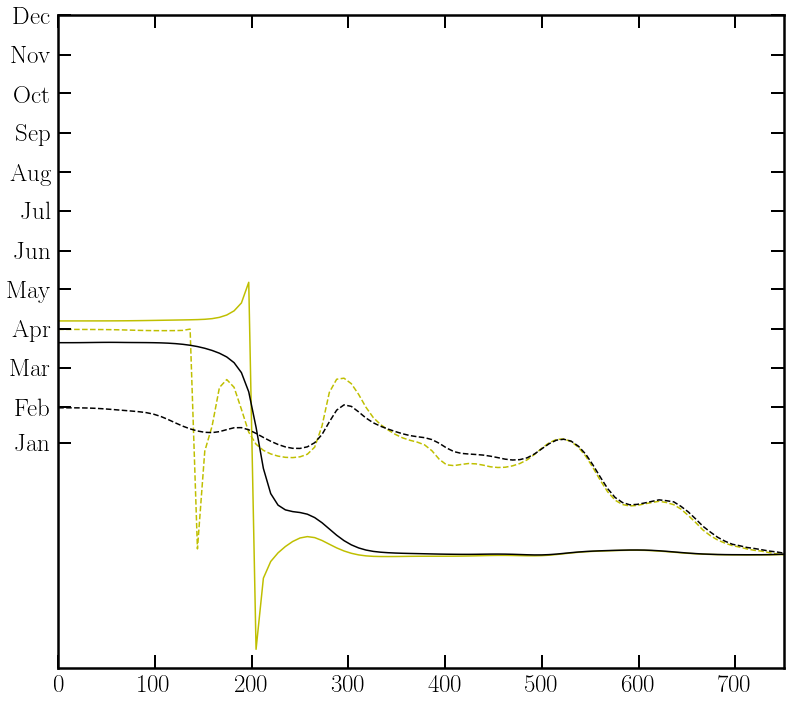

In [38]:
w = 2*pi/1.0
t0 = 0.18

def ti(a,b,n):
    ai = a[n-1,:]
    bi = b[n-1,:]
    nwt = n*w*t0
    ti = -(1.0/(n*w))*arctan2((ai*sin(nwt)-bi*cos(nwt)),(ai*cos(nwt)+bi*sin(nwt)))
    return ti 

fig,ax1 = MySquarePlot()

A0,a,b = FourierComponents(g,nc)
plt.plot(v_min,365*(-ti(a,b,2)),'y--',lw=1.5,zorder=zorder+1)
plt.plot(v_min,365*(-ti(a,b,1)),'y-',lw=1.5,zorder=zorder+1)

A0,a,b = FourierComponents(g_gf,nc)
plt.plot(v_min,365*(-ti(a,b,2)),'k--',lw=1.5,zorder=zorder+1)
plt.plot(v_min,365*(-ti(a,b,1)),'k-',lw=1.5,zorder=zorder+1)

plt.xlim([0.0,750.0])

plt.yticks(cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31,
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
           rotation=0)
#plt.ylim([130.0,365.0])

In [ ]:
# Saving f(v) modulations

# v_mins
n = 100
v = linspace(0.01,750.0,n)

# Times
ndays = 25
days = linspace(0.0,365.0-365.0/ndays,ndays)

# Calculate everything
fv_Iso = zeros(shape=(ndays,n))
fv_Iso_gf = zeros(shape=(ndays,n))
fv_Saus = zeros(shape=(ndays,n))
fv_Saus_gf = zeros(shape=(ndays,n))
fv_sub = zeros(shape=(ndays,n))
fv_sub_gf = zeros(shape=(ndays,n))
for i in range(0,ndays):
    fv_Iso[i,:] = SpeedDist_Triaxial_alt(v,days[i],sig_iso)
    fv_Iso_gf[i,:] = SpeedDist_Triaxial_alt(v,days[i],sig_iso,GravFocus=True)
    
    fv_Saus[i,:] = SpeedDist_Triaxial_alt(v,days[i],sig_beta)
    fv_Saus_gf[i,:] = SpeedDist_Triaxial_alt(v,days[i],sig_beta,GravFocus=True)

    for isub in range(0,nshards):
        v_s = velocities[isub,:]
        sig_s = dispersions[isub,:]
        fv_sub[i,:] += weights[isub]*SpeedDist_Triaxial_alt(v,days[i],sig_s,v_shift=v_s)
        fv_sub_gf[i,:] += weights[isub]*SpeedDist_Triaxial_alt(v,days[i],sig_s,v_shift=v_s,GravFocus=True)
    
    
    print('day = ',i,'of',ndays,sum(fv_sub[i,:]),sum(fv_sub_gf[i,:]))

day =  0 of 25 0.13169597469059266 0.1325085517235861
day =  1 of 25 0.1316989841208513 0.13290191007094246
day =  2 of 25 0.1316962190139773 0.13349842015631203
day =  3 of 25 0.131689684833406 0.1340576375525316
day =  4 of 25 0.13168393394707084 0.134430161925394
day =  5 of 25 0.1316775111466252 0.1344376868957021
day =  6 of 25 0.13166967853209915 0.13353217390888053
day =  7 of 25 0.13166133226653012 0.13270284305364413
day =  8 of 25 0.13165968916502918 0.13229938339515826
day =  9 of 25 0.13166452199148923 0.13212684818576706
day =  10 of 25 0.13166697986021883 0.13258074547503748
day =  11 of 25 0.13166765196402863 0.1324056194957844


(0.0, 700.0)

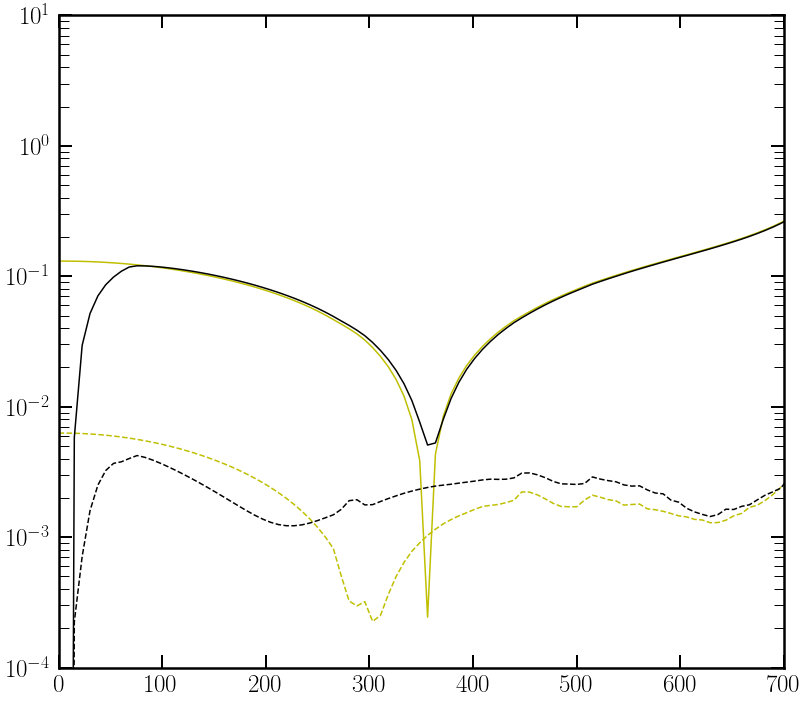

In [43]:
fig,ax1 = MySquarePlot()

xi = 0.0
eta = 0.0
fv = (1-xi-eta)*fv_Iso+eta*fv_Saus + xi*fv_sub
fv_gf = (1-xi-eta)*fv_Iso_gf+eta*fv_Saus_gf + xi*fv_sub_gf

A0,a,b = FourierComponents(fv,nc)
A1 = sqrt(a[0,:]**2.0+b[0,:]**2.0)
A2 = sqrt(a[1,:]**2.0+b[1,:]**2.0)
plt.plot(v_min,A2/A0,'y--',lw=1.5,zorder=zorder+1)
plt.plot(v_min,A1/A0,'y-',lw=1.5,zorder=zorder+1)

A0,a,b = FourierComponents(fv_gf,nc)
A1 = sqrt(a[0,:]**2.0+b[0,:]**2.0)
A2 = sqrt(a[1,:]**2.0+b[1,:]**2.0)
plt.plot(v_min,A2/A0,'k--',lw=1.5,zorder=zorder+1)
plt.plot(v_min,A1/A0,'k-',lw=1.5,zorder=zorder+1)

plt.yscale('log')
plt.ylim([1e-4,1e1])
plt.xlim([0.0,700.0])